In [1]:
import sys
from pathlib import Path
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import torch

from fast_ctc_decode import beam_search, viterbi_search
from feito.augmentation.flip import flip
from feito.augmentation.gaussian_noise import gaussian_noise

from feito.dataloaders.training import DatasetONT
from feito.models import Rodan


In [3]:
MODEL = "Rodan"
PATH_CHECKPOINT = "../output-rodan-smoothctc-ranger/training/checkpoints/Rodan-epoch28.pt"
ALPHABET = "NACGT"
LEN_OUTPUT=271

In [4]:
dataset = DatasetONT("../data/subsample_val.hdf5", 420)

In [10]:
idx = 2 
signal, label, _, _ = dataset[idx]
signal

tensor([[-1.0564, -0.8126, -0.9589,  ...,  0.0975, -0.4632, -0.5363]])

In [11]:
gn_signal, gn_label = gaussian_noise(signal, label, prob=1)

In [12]:
len(label)


271

In [51]:
torch.flip(signal, (0,1))

tensor([[-0.5363, -0.4632,  0.0975,  ..., -0.9589, -0.8126, -1.0564]])

In [52]:
non0_label = label[label.nonzero().squeeze().detach()]#,(0,1))
non0_label

tensor([2, 1, 2, 2, 3, 4, 2, 3, 2, 2, 3, 4, 2, 3, 1, 1, 2, 3, 1, 2, 2, 2, 1, 2,
        2, 3, 4, 4, 3, 4, 3, 3, 2, 2, 1, 2, 1, 2, 4, 4, 1, 1, 3, 3, 3, 1, 1, 3,
        1, 1, 2, 2, 4, 3, 1, 3, 4, 4, 3, 4, 1, 1, 2, 1, 1, 1, 2, 4, 2, 3, 1, 2,
        4, 2, 2, 3, 2, 2, 4, 1, 2, 2, 4, 4, 2, 3, 1, 2, 3, 1, 2, 2, 4, 4, 2, 4,
        2, 3, 2, 3, 4, 1, 1, 1, 3, 1, 2, 4, 4, 3])

In [53]:
torch.flip(non0_label, (-1,))

tensor([3, 4, 4, 2, 1, 3, 1, 1, 1, 4, 3, 2, 3, 2, 4, 2, 4, 4, 2, 2, 1, 3, 2, 1,
        3, 2, 4, 4, 2, 2, 1, 4, 2, 2, 3, 2, 2, 4, 2, 1, 3, 2, 4, 2, 1, 1, 1, 2,
        1, 1, 4, 3, 4, 4, 3, 1, 3, 4, 2, 2, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 4, 4,
        2, 1, 2, 1, 2, 2, 3, 3, 4, 3, 4, 4, 3, 2, 2, 1, 2, 2, 2, 1, 3, 2, 1, 1,
        3, 2, 4, 3, 2, 2, 3, 2, 4, 3, 2, 2, 1, 2])

In [54]:
missing_pos = LEN_OUTPUT - len(non0_label)
torch.nn.functional.pad(non0_label,(0,missing_pos),value=0)

tensor([2, 1, 2, 2, 3, 4, 2, 3, 2, 2, 3, 4, 2, 3, 1, 1, 2, 3, 1, 2, 2, 2, 1, 2,
        2, 3, 4, 4, 3, 4, 3, 3, 2, 2, 1, 2, 1, 2, 4, 4, 1, 1, 3, 3, 3, 1, 1, 3,
        1, 1, 2, 2, 4, 3, 1, 3, 4, 4, 3, 4, 1, 1, 2, 1, 1, 1, 2, 4, 2, 3, 1, 2,
        4, 2, 2, 3, 2, 2, 4, 1, 2, 2, 4, 4, 2, 3, 1, 2, 3, 1, 2, 2, 4, 4, 2, 4,
        2, 3, 2, 3, 4, 1, 1, 1, 3, 1, 2, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])

In [ ]:
def flip(signal, label):
    len_output = 271

    non0_label = label[label.nonzero().squeeze().detach()]
    non0_label = torch.flip(non0_label, (-1,))
    
    missing_pos = len_output - len(non0_label)

    rev_seq   = torch.flip(signal, (0,1))
    rev_label = torch.nn.functional.pad(non0_label,(0,missing_pos),value=0)

    return rev_seq, rev_label

**Plot signal and its reverse signal**

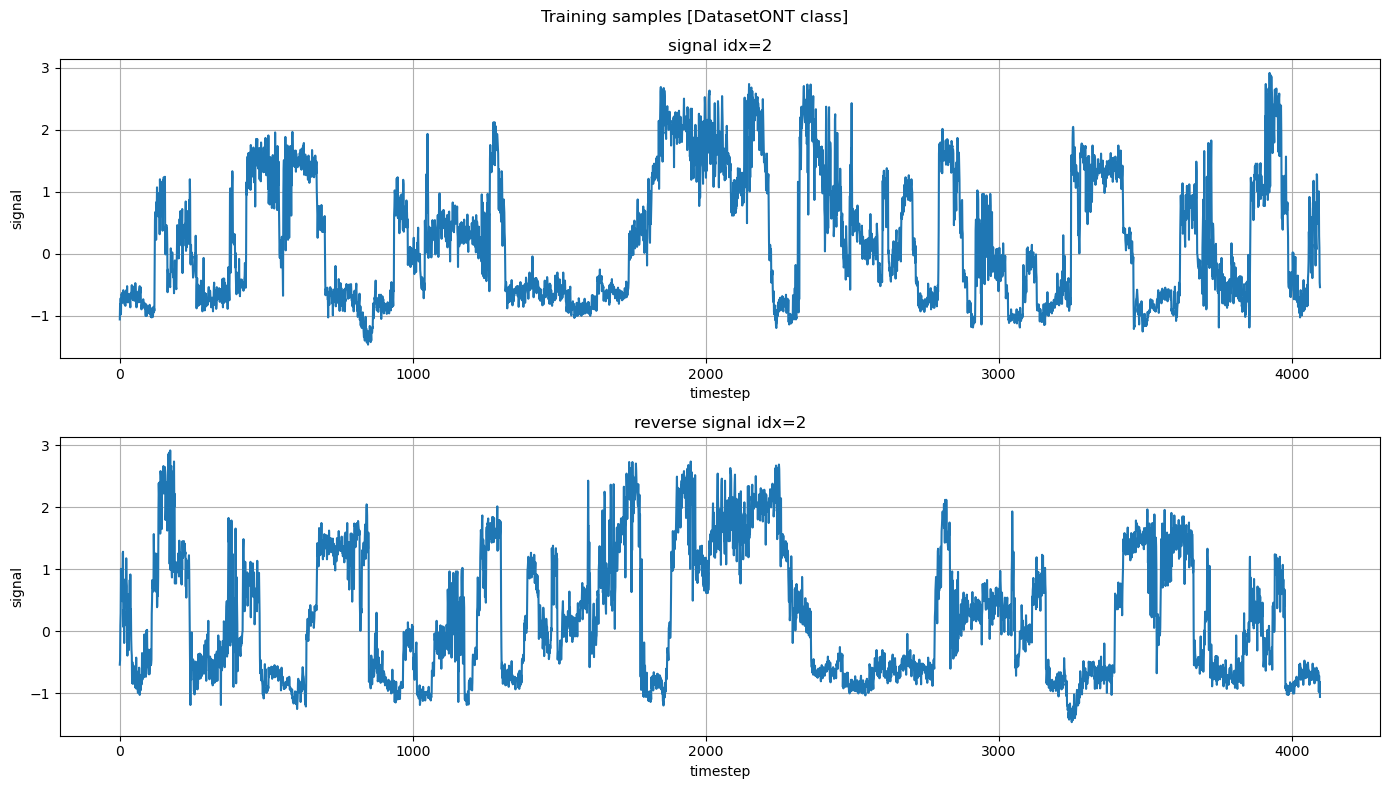

In [24]:
fig, axs= plt.subplots(2, figsize=(14,8), sharex="row", sharey="col")

signal, label, _,  _ = dataset[idx]
tsteps = range(len(signal[0]))
    
# plot forward signal
axs.flat[0].plot(tsteps, signal[0])
axs.flat[0].set_title(f"signal idx={idx}")
axs.flat[0].set_xlabel("timestep")
axs.flat[0].set_ylabel("signal")
axs.flat[0].grid(True)

# reverse signal
rev_signal = torch.flip(signal, (0,1))
axs.flat[1].plot(tsteps, rev_signal[0])
axs.flat[1].set_title(f"reverse signal idx={idx}")
axs.flat[1].set_xlabel("timestep")
axs.flat[1].set_ylabel("signal")
axs.flat[1].grid(True)

In [25]:
model=eval(f"{MODEL}()")
model_output_len = model.output_len
model.to("cpu")
model.load_state_dict(torch.load(PATH_CHECKPOINT, map_location=torch.device('cpu'))["weights"])
model.eval()

CONFIG(vocab=['<PAD>', 'A', 'C', 'G', 'T'], activation='mish', sqex_activation='mish', dropout=0.1, sqex_reduction=32)
Activation Function is: mish
Activation Function is: mish


Rodan(
  (convlayers): Sequential(
    (conv0): ConvBlockRodan(
      (conv): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Mish()
      (sqex): SqueezeExcite(
        (avg): AdaptiveAvgPool1d(output_size=1)
        (fc1): Linear(in_features=256, out_features=32, bias=True)
        (activation): Mish()
        (fc2): Linear(in_features=32, out_features=256, bias=True)
        (sigmoid): Sigmoid()
      )
    )
    (conv1): ConvBlockRodan(
      (depthwise): Conv1d(256, 256, kernel_size=(10,), stride=(1,), padding=(5,), groups=256, bias=False)
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Mish()
      (sqex): SqueezeExcite(
        (avg): AdaptiveAvgPool1d(output_size=1)
        (fc1): Linear(in_features=256, out_features=32, bias=True)
        (activation): Mish()
        (fc2): Linear(in_feat

In [26]:
pred_forward = model(torch.unsqueeze(signal,0))
pred_forward.shape

torch.Size([420, 1, 5])

In [27]:
pred_reverse = model(torch.unsqueeze(rev_signal,0))

In [28]:
torch.squeeze(pred_forward,0).shape

torch.Size([420, 1, 5])

In [29]:
seq_forward, _ = viterbi_search(
    torch.softmax(pred_forward[:,0,:], dim=-1).detach().numpy(), 
    ALPHABET) 

In [30]:
seq_reverse, _ = viterbi_search(
    torch.softmax(pred_reverse[:,0,:], dim=-1).detach().numpy(), 
    ALPHABET) 

In [31]:
seq_forward

'ACCGTCGCCGTCGAACGACCACCACCGTTGTGGCCACACTTAAGGGAAGAACCTGAGTTGTAACAAACTCGACTCCGCCTACCTTCGACGACCTTCTCGCGTAAAGACTT'

In [32]:
seq_reverse

'TAGCAGCCACCTAAAACACTACCAAGTAAACAAACGTATGCCATCAGTTCTAAGCGCACCTCTTAAAACAGCTACC'